In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


# Imports

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from sustaingym.algorithms.evcharging.base_algorithm import SelectiveChargingAlgorithm, GreedyAlgorithm, PPOAlgorithm, RandomAlgorithm
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv
from sustaingym.envs.evcharging.event_generation import RealTraceGenerator

# Run Charging Algorithms

In [31]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

date_range = ('2018-11-05', '2018-11-11')

generator = RealTraceGenerator(site='caltech', date_range=date_range, sequential=True, period=5)
eval_env = EVChargingEnv(generator, action_type='discrete')

eval_env.reset()

algs = [SelectiveChargingAlgorithm(rate=1.0), SelectiveChargingAlgorithm(rate=2.0), GreedyAlgorithm(), RandomAlgorithm()]

def collect_rewards(env, algs):
    begin = datetime.strptime(date_range[0], DATE_FORMAT)
    end = datetime.strptime(date_range[1], DATE_FORMAT)
    days_diff = end - begin
    num_days_sim = days_diff.days + 1

    results = {}
    for alg in algs:
        print(f"Running {alg.name}")
        results[alg] = alg.run(env, num_days_sim) # num_days_sim
    results = {alg.name: reward for alg, reward in results.items()}

    results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    results = pd.DataFrame(results)
    results.set_index('dates', inplace=True)
    return results

heuristics_rewards = collect_rewards(eval_env, algs)
heuristics_rewards

Running selective charge @ rate 8.0 A
Running selective charge @ rate 16.0 A
Running optimal greedy
Running random


,selective charge @ rate 8.0 A,selective charge @ rate 16.0 A,optimal greedy,random
dates,,,,
2018-11-05,-6.016314,-0.889558,1.604526,-144.965033
2018-11-06,-4.919644,-1.101987,0.806359,-142.949310
2018-11-07,-7.432247,-3.045260,-0.146353,-152.237849
2018-11-08,-5.761163,-1.657067,0.188155,-150.016680
2018-11-09,-5.603462,-3.584577,-0.871026,-149.996898
2018-11-10,-2.484192,-1.159038,0.248122,-154.180353
2018-11-11,-6.910859,-1.566199,2.191016,-141.614862


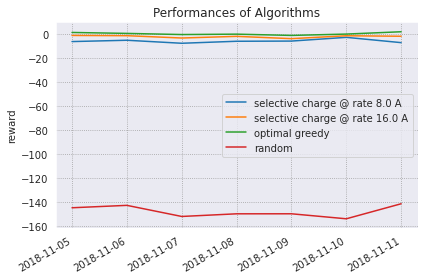

In [32]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    plt.plot(heuristics_rewards[col], label=col)
plt.ylabel('reward')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

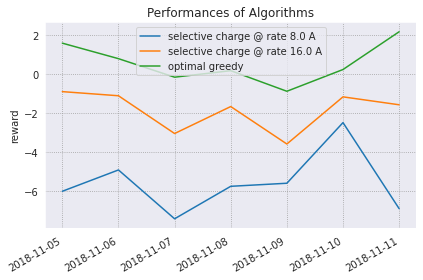

In [33]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    if col == 'random':
        continue
    plt.plot(heuristics_rewards[col], label=col)
plt.ylabel('reward')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

# Train a PPO Agent

In [6]:
# Create train environment, same parameters as test environment
generator = RealTraceGenerator(site='caltech', date_range=date_range, sequential=True, period=5)
train_env = EVChargingEnv(generator, action_type='discrete')

model = PPO('MultiInputPolicy', train_env, verbose=0)
rl_algo = PPOAlgorithm(model)

trained_rewards = {}
num_steps = 0
timesteps = 25_000
for _ in range(10):
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])
    num_steps += timesteps
    model.learn(total_timesteps=timesteps)
    print("num timesteps: ", num_steps)

trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
display(trained_rewards[num_steps])


Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,8.140252
2018-11-06,6.322983
2018-11-07,8.787707
2018-11-08,7.721678
2018-11-09,-2.360163
2018-11-10,-2.634657
2018-11-11,8.380478


num timesteps:  25000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,7.900165
2018-11-06,6.651745
2018-11-07,8.885607
2018-11-08,7.521063
2018-11-09,-2.500333
2018-11-10,-2.749781
2018-11-11,8.252007


num timesteps:  50000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,8.816223
2018-11-06,6.915234
2018-11-07,8.931072
2018-11-08,7.509992
2018-11-09,-1.933674
2018-11-10,-2.924609
2018-11-11,8.849332


num timesteps:  75000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,8.989373
2018-11-06,7.282276
2018-11-07,9.652091
2018-11-08,8.482958
2018-11-09,-0.850727
2018-11-10,-1.812420
2018-11-11,9.520929


num timesteps:  100000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,9.592267
2018-11-06,7.955939
2018-11-07,10.500230
2018-11-08,8.770460
2018-11-09,-0.655723
2018-11-10,-1.218809
2018-11-11,9.739662


num timesteps:  125000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,9.667278
2018-11-06,8.453872
2018-11-07,10.536994
2018-11-08,9.001753
2018-11-09,0.011112
2018-11-10,-1.023563
2018-11-11,9.699150


num timesteps:  150000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,10.438263
2018-11-06,8.386844
2018-11-07,10.556514
2018-11-08,9.641307
2018-11-09,0.368637
2018-11-10,-1.061777
2018-11-11,10.556178


num timesteps:  175000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,10.670328
2018-11-06,8.947433
2018-11-07,10.617649
2018-11-08,9.470647
2018-11-09,0.574704
2018-11-10,-0.481934
2018-11-11,10.465582


num timesteps:  200000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,10.782016
2018-11-06,9.348244
2018-11-07,10.811522
2018-11-08,9.702067
2018-11-09,1.334824
2018-11-10,-0.041392
2018-11-11,10.893542


num timesteps:  225000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,10.906703
2018-11-06,9.006484
2018-11-07,11.449315
2018-11-08,9.837156
2018-11-09,1.210206
2018-11-10,0.075863
2018-11-11,11.584769


num timesteps:  250000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,11.335065
2018-11-06,9.262555
2018-11-07,11.388163
2018-11-08,10.238161
2018-11-09,1.935037
2018-11-10,-0.000564
2018-11-11,11.518979


In [7]:
model.save("ppo_agent_scheduler")

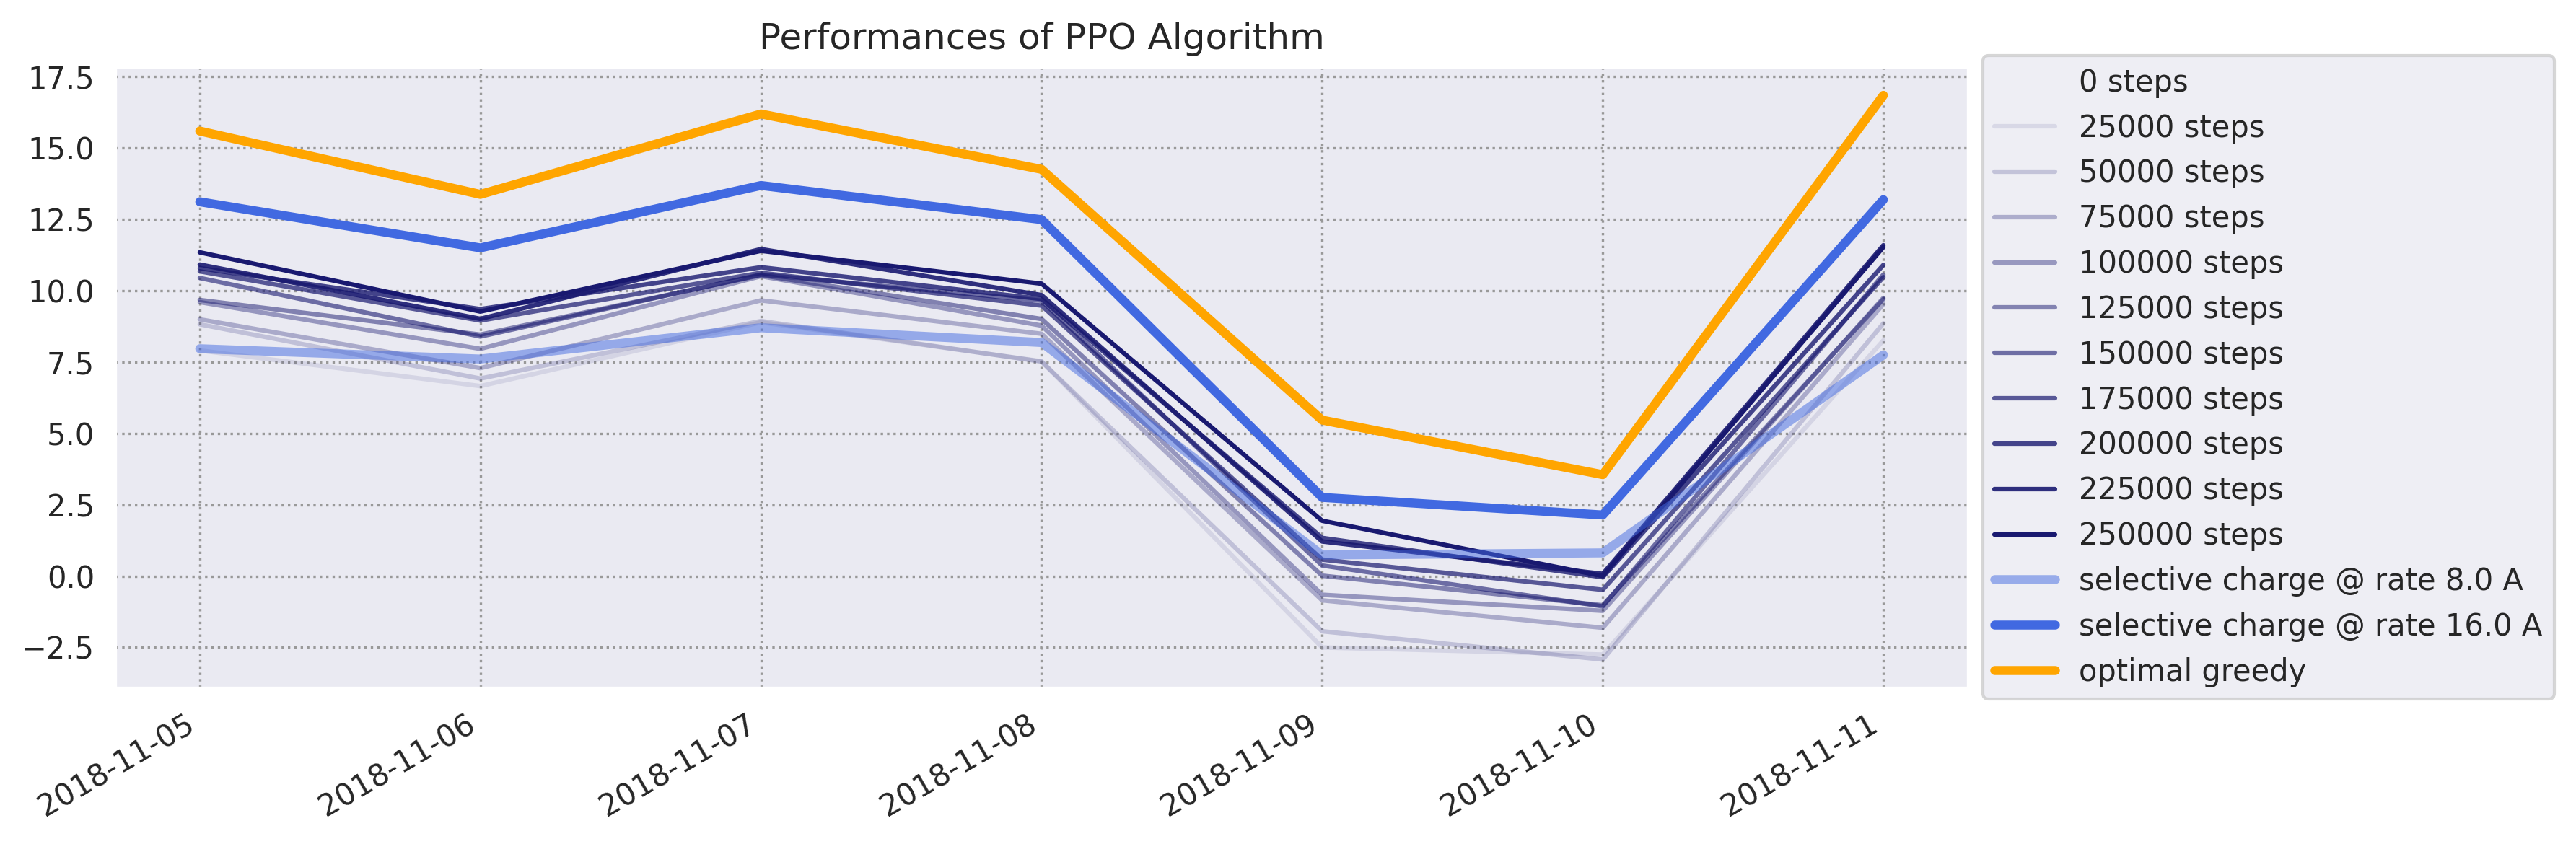

In [47]:
plt.figure(figsize=(12, 4), dpi=300)

training_results = pd.concat([trained_rewards[i * timesteps] for i in range(11)], axis=1)
training_results.columns = [f"{i * timesteps} steps" for i in range(11)]
training_results

all_results = pd.concat((training_results, heuristics_rewards), axis=1)

plt.title("Performances of PPO Algorithm")
for col in all_results.columns:
    if 'steps' in col:
        alpha = int(col.split(' ')[0]) / 250000
        plt.plot(all_results[col], label=col, alpha=alpha, color='midnightblue')
    elif 'charge' in col and '8.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=0.5, lw=3.)
    elif 'charge' in col and '16.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=1.0, lw=3.)
    else:
        plt.plot(all_results[col], label=col, color='orange', lw=3.)
plt.gcf().autofmt_xdate()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()